In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
# preprocessing
import re
import string
import nltk
from nltk import  pos_tag
from nltk.corpus import stopwords
import nltk.stem as stemmer

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec


from collections import Counter
# Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report



In [2]:
#read data
dataset= pd.read_csv('gossipcop_stp_fS_fe_stm.csv')
dataset

,news,polarity,source,label
0,donald glover,0.00,0,1
1,everything know kevin harts alleged extortion ...,-0.10,1,0
2,oscars memorable academy awards acceptance spe...,0.50,2,1
3,ariana grande arrives england manchester benef...,0.00,3,1
4,prince royce goes shirtless dancing underwear ...,0.25,4,1
...,...,...,...,...
19992,would thought kylie would successful kardashian,0.75,807,0
19993,beyonce shows flawless figure serena williams ...,1.00,34,1
19994,met gala katy perry flew kim kardashians nails la,0.00,1,1
19995,caitlyn jenner caught dinner date ex girlfrien...,0.00,185,0


In [3]:
print((dataset.label == 1).sum()) # real news number
print((dataset.label == 0).sum()) # fake news number

15167
4830


In [4]:
#rename the title column to news
dataset.rename(columns= {'title': 'news'}, inplace= True)

In [5]:
df= dataset[['news']]
label= dataset[['label']]
other_features= dataset.drop(['news', 'label'], axis= 1)
df.head(3)

,news
0,donald glover
1,everything know kevin harts alleged extortion ...
2,oscars memorable academy awards acceptance spe...


In [6]:
# cleanning dataset

In [7]:
def remove_URL(text):
  url= re.compile(r'https?://\S+|www\.|S+')
  return url.sub(r"", text)

In [8]:
def remove_punctuation(text):
  trnsltr= str.maketrans("","", string.punctuation)
  return text.translate(trnsltr)

In [9]:
df['news']= df.news.map(remove_punctuation)
df['news']= df.news.map(remove_URL)

<ipython-input-9-a35a6abdf14c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df.news.map(remove_punctuation)
<ipython-input-9-a35a6abdf14c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df.news.map(remove_URL)


In [10]:
#remove stop words

In [11]:
nltk.download('stopwords')
stop= set(stopwords.words("english"))
def remove_stopwords(text):
  result= [word.lower() for word in text.split() if word.lower() not in stop]
  return ' '.join(result)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df['news']= df.news.map(remove_stopwords)

<ipython-input-12-b1b16693267d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df.news.map(remove_stopwords)


In [13]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
from nltk.stem import *
from nltk.stem.porter import *
stemmer = PorterStemmer()

pos= pos_tag(df['news'])
df['news'] = [stemmer.stem(tagged_word[0]) for tagged_word in pos]



<ipython-input-14-75a18c877c3d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'] = [stemmer.stem(tagged_word[0]) for tagged_word in pos]


In [15]:
df

,news
0,donald glov
1,everything know kevin harts alleged extortion ...
2,oscars memorable academy awards acceptance speech
3,ariana grande arrives england manchester benef...
4,prince royce goes shirtless dancing underwear ...
...,...
19992,would thought kylie would successful kardashian
19993,beyonce shows flawless figure serena williams wed
19994,met gala katy perry flew kim kardashians nails la
19995,caitlyn jenner caught dinner date ex girlfrien...


In [16]:
# counting unique words of news column
def count_words(text_col):
  counter= Counter()
  for text in text_col:
    for word in text.split():
      counter[word] += 1
  return counter


In [17]:
counter= count_words(df['news'])

In [18]:
# number of unique words
len(counter)

20735

In [19]:
unique_words_num= len(counter)

In [20]:
embedding_dim= 100

In [21]:
# Word2Vec

In [22]:
X= [x.split() for x in df['news'].tolist()]

In [23]:
print(X[0])

['donald', 'glov']


In [24]:
w2v_mdl= Word2Vec(sentences= X, window= 10, min_count=1 )

In [25]:
len(w2v_mdl.wv.index_to_key)

20735

In [26]:
# most similarity of 5 most common words

In [27]:
print(most_common:= counter.most_common(5))

[('new', 1018), ('kardashian', 970), ('jennifer', 724), ('kim', 645), ('season', 589)]


In [28]:
print('word is: ',wrd:= most_common[0][0])
w2v_mdl.wv.most_similar(wrd)

word is:  new


[('goes', 0.9991451501846313),
 ('concert', 0.9988021850585938),
 ('beyoncé', 0.9987795352935791),
 ('home', 0.9987487196922302),
 ('give', 0.9987163543701172),
 ('emotional', 0.998708963394165),
 ('gift', 0.9986947178840637),
 ('fake', 0.998670220375061),
 ('house', 0.9986678957939148),
 ('hair', 0.9986645579338074)]

In [29]:
print('word is: ',wrd:= most_common[1][0])
w2v_mdl.wv.most_similar(wrd)

word is:  kardashian


[('kanye', 0.9917224645614624),
 ('west', 0.9900138974189758),
 ('saint', 0.9861228466033936),
 ('wests', 0.9846968650817871),
 ('khloe', 0.9819588661193848),
 ('cattrall', 0.9806944131851196),
 ('tristan', 0.9806145429611206),
 ('kim', 0.9802826642990112),
 ('khloé', 0.9802665710449219),
 ('thompson', 0.9781670570373535)]

In [30]:
print('word is: ',wrd:= most_common[2][0])
w2v_mdl.wv.most_similar(wrd)

word is:  jennifer


[('affleck', 0.9883584976196289),
 ('rodriguez', 0.9872601628303528),
 ('aronofsky', 0.9870384335517883),
 ('alex', 0.9856786727905273),
 ('courteney', 0.9842956066131592),
 ('lawrence', 0.9840560555458069),
 ('garner', 0.9792057275772095),
 ('lopezs', 0.9789650440216064),
 ('casually', 0.9789186716079712),
 ('lopez', 0.9784950017929077)]

In [31]:
print('word is: ',wrd:= most_common[3][0])
w2v_mdl.wv.most_similar(wrd)

word is:  kim


[('khloe', 0.9963376522064209),
 ('khloé', 0.9950051307678223),
 ('wests', 0.9931265115737915),
 ('tristan', 0.9925058484077454),
 ('west', 0.9920579791069031),
 ('thompson', 0.9911680817604065),
 ('kanye', 0.990503191947937),
 ('kourtney', 0.9885752201080322),
 ('kuwtk', 0.9883404970169067),
 ('surrogate', 0.9863811731338501)]

In [32]:
print('word is: ',wrd:= most_common[4][0])
w2v_mdl.wv.most_similar(wrd)

word is:  season


[('premiere', 0.9988766312599182),
 ('star', 0.9985666275024414),
 ('series', 0.9984685778617859),
 ('trailer', 0.9983885884284973),
 ('cast', 0.9983813166618347),
 ('finale', 0.9981799721717834),
 ('episode', 0.998087465763092),
 ('stars', 0.9979003071784973),
 ('ratings', 0.9978751540184021),
 ('live', 0.9978693127632141)]

In [33]:
# vectorize a text into a sequence of integers by tokenizing
# converting text into a sequence of integers
def tokenize(text):
  tokenizer= Tokenizer(num_words= unique_words_num)
  tokenizer.fit_on_texts(text)
  return tokenizer

In [34]:
tokenizer= tokenize(X)


In [35]:
print(word_index:= tokenizer.word_index)

{'new': 1, 'kardashian': 2, 'jennifer': 3, 'kim': 4, 'season': 5, 'jenner': 6, 'star': 7, 'meghan': 8, 'justin': 9, 'prince': 10, 'baby': 11, 'first': 12, 'says': 13, 'wedding': 14, 'brad': 15, '–': 16, 'selena': 17, 'reveals': 18, '—': 19, 'watch': 20, 'best': 21, 'show': 22, 'taylor': 23, 'see': 24, 'video': 25, 'pitt': 26, 'kylie': 27, 'harry': 28, 'gomez': 29, 'kate': 30, 'awards': 31, 'split': 32, 'angelina': 33, 'back': 34, 'photo': 35, 'markle': 36, 'report': 37, 'get': 38, 'award': 39, 'scott': 40, 'tv': 41, 'royal': 42, 'blake': 43, 'stars': 44, 'relationship': 45, 'chris': 46, 'birthday': 47, 'family': 48, 'aniston': 49, 'west': 50, 'love': 51, 'day': 52, 'look': 53, 'kanye': 54, 'khloe': 55, 'jolie': 56, 'swift': 57, 'daughter': 58, 'bieber': 59, 'pregnant': 60, 'music': 61, 'dating': 62, 'red': 63, 'shares': 64, 'bella': 65, 'james': 66, 'mom': 67, 'trump': 68, 'secret': 69, 'tom': 70, 'real': 71, 'ryan': 72, 'year': 73, 'divorce': 74, 'us': 75, 'inside': 76, 'know': 77, 'w

In [36]:
tokenizer.word_counts

OrderedDict([('donald', 101),
             ('glov', 2),
             ('everything', 136),
             ('know', 203),
             ('kevin', 86),
             ('harts', 6),
             ('alleged', 60),
             ('extortion', 7),
             ('case', 23),
             ('cheating', 90),
             ('scand', 51),
             ('oscars', 92),
             ('memorable', 17),
             ('academy', 18),
             ('awards', 332),
             ('acceptance', 10),
             ('speech', 55),
             ('ariana', 100),
             ('grande', 75),
             ('arrives', 10),
             ('england', 7),
             ('manchester', 39),
             ('benefit', 14),
             ('concert', 68),
             ('prince', 501),
             ('royce', 4),
             ('goes', 73),
             ('shirtless', 25),
             ('dancing', 93),
             ('underwear', 8),
             ('watch', 392),
             ('hot', 58),
             ('video', 359),
             ('nikki', 10

In [37]:
text_sentences= df['news'].to_numpy()
text_sequences= tokenizer.texts_to_sequences(X)


In [38]:
print(text_sentences[100])
print(text_sequences[100])

kim kardashians diet fitness routine left feeling stronger tight
[4, 157, 888, 1278, 2503, 721, 1323, 3250, 2724]


In [39]:
#reversing tokenization
# test_sequences

In [40]:
# min and max lengh of train sequences
train_min_lenght= len(min(text_sequences, key= len))
train_max_lenght= len(max(text_sequences, key= len))
train_min_lenght , train_max_lenght


(1, 26)

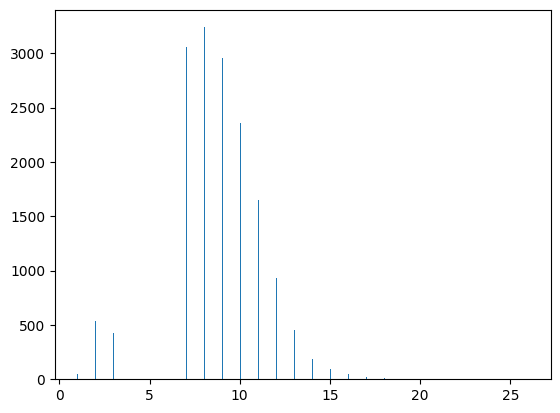

In [41]:
# plotting len of each sentence
plt.hist([len(x) for x in X], bins=500);

In [42]:
sentence_len= np.array([len(x) for x in X])
print(f'There are {len(sentence_len[sentence_len > 15])} sentences which have more than 25 words.')
max_len= 15

There are 92 sentences which have more than 25 words.


In [43]:
# padding
def padding_sequences(seq, max_len):
  return pad_sequences(seq, maxlen= max_len, padding= "post", truncating="post")

In [44]:
text_padded= padding_sequences(text_sequences, max_len)

In [45]:
print(text_sentences[100])
print(text_sequences[100])
print(text_padded[100])

kim kardashians diet fitness routine left feeling stronger tight
[4, 157, 888, 1278, 2503, 721, 1323, 3250, 2724]
[   4  157  888 1278 2503  721 1323 3250 2724    0    0    0    0    0
    0]


In [46]:
# checking tokenization by reversing from sequences to sentences
# filp word_index dictionay index and value
reversed_index= dict([(idx, word) for (word, idx) in word_index.items()])

In [47]:
def decode(seq):
  result= " ".join([reversed_index.get(idx, "?") for idx in seq])
  return result

In [48]:
decoded_news= decode(text_sequences[100])
print(text_sequences[100])
print(text_sentences[100])
print(decoded_news)

[4, 157, 888, 1278, 2503, 721, 1323, 3250, 2724]
kim kardashians diet fitness routine left feeling stronger tight
kim kardashians diet fitness routine left feeling stronger tight


In [49]:
#concatinating other features to tokenized data

In [50]:
full_df_padded= np.hstack([text_padded, other_features])
max_len+= len(other_features.columns)


In [51]:
# vocab_size
vocab_size= len(tokenizer.word_index) +1 # because word_index starts from zero

In [52]:
def get_weight_matrix(model):
  weight_matrix= np.zeros((vocab_size, embedding_dim))
  for word, i in tokenizer.word_index.items():
    weight_matrix[i]= model.wv[word]
  return weight_matrix


In [53]:
embedding_vectors= get_weight_matrix(w2v_mdl)

In [54]:
X_train, X_test, y_train, y_test= train_test_split(full_df_padded, label, test_size= 0.2, random_state= 10)

In [55]:

# create LSTM model
model= keras.models.Sequential()
model.add(layers.Embedding(vocab_size, output_dim= embedding_dim,  weights=[embedding_vectors], input_length= max_len , trainable=False)) # with other features
model.add(layers.LSTM(128, dropout= 0.1))
model.add(layers.Dense(1,  activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 100)           2073600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,190,977
Trainable params: 117,377
Non-trainable params: 2,073,600
_________________________________________________________________


In [56]:
loss= keras.losses.BinaryCrossentropy(from_logits= False)
optim= keras.optimizers.Adam(learning_rate=0.005)
metrics= ["accuracy"]#,  Precision(), Recall()]
model.compile(loss= loss, optimizer= optim, metrics= metrics)

In [57]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)


Epoch 1/50
500/500 - 14s - loss: 0.5534 - accuracy: 0.7569 - val_loss: 0.5395 - val_accuracy: 0.7675 - 14s/epoch - 27ms/step
Epoch 2/50
500/500 - 2s - loss: 0.5035 - accuracy: 0.7787 - val_loss: 0.4657 - val_accuracy: 0.8012 - 2s/epoch - 5ms/step
Epoch 3/50
500/500 - 2s - loss: 0.4667 - accuracy: 0.8009 - val_loss: 0.4358 - val_accuracy: 0.8138 - 2s/epoch - 4ms/step
Epoch 4/50
500/500 - 3s - loss: 0.4428 - accuracy: 0.8148 - val_loss: 0.4217 - val_accuracy: 0.8265 - 3s/epoch - 6ms/step
Epoch 5/50
500/500 - 2s - loss: 0.4330 - accuracy: 0.8185 - val_loss: 0.4181 - val_accuracy: 0.8285 - 2s/epoch - 5ms/step
Epoch 6/50
500/500 - 2s - loss: 0.4265 - accuracy: 0.8205 - val_loss: 0.4212 - val_accuracy: 0.8245 - 2s/epoch - 5ms/step
Epoch 7/50
500/500 - 2s - loss: 0.4229 - accuracy: 0.8261 - val_loss: 0.4109 - val_accuracy: 0.8290 - 2s/epoch - 5ms/step
Epoch 8/50
500/500 - 2s - loss: 0.4206 - accuracy: 0.8262 - val_loss: 0.4076 - val_accuracy: 0.8335 - 2s/epoch - 5ms/step
Epoch 9/50
500/500 - 

In [58]:
y_pred= (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

125/125 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       943
           1       0.85      0.92      0.88      3057

    accuracy                           0.82      4000
   macro avg       0.75      0.70      0.72      4000
weighted avg       0.80      0.82      0.81      4000



In [59]:
# Bidirectional LSTM

In [60]:
bi_model =  keras.models.Sequential()
bi_model.add(layers.Embedding(vocab_size, output_dim= embedding_dim,  weights=[embedding_vectors], input_length= max_len , trainable=False))
bi_model.add(layers.Bidirectional(layers.LSTM(128, dropout=0.1)))  # Use Bidirectional LSTM layer
bi_model.add(layers.Dense(1, activation='sigmoid'))
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["accuracy"] #, Precision(), Recall()]

bi_model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [61]:
bi_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)


Epoch 1/50
500/500 - 9s - loss: 0.5058 - accuracy: 0.7821 - val_loss: 0.4727 - val_accuracy: 0.7910 - 9s/epoch - 17ms/step
Epoch 2/50
500/500 - 3s - loss: 0.4730 - accuracy: 0.7918 - val_loss: 0.4555 - val_accuracy: 0.8023 - 3s/epoch - 7ms/step
Epoch 3/50
500/500 - 3s - loss: 0.4670 - accuracy: 0.7961 - val_loss: 0.4530 - val_accuracy: 0.8040 - 3s/epoch - 6ms/step
Epoch 4/50
500/500 - 4s - loss: 0.4627 - accuracy: 0.7990 - val_loss: 0.4496 - val_accuracy: 0.8108 - 4s/epoch - 7ms/step
Epoch 5/50
500/500 - 3s - loss: 0.4600 - accuracy: 0.7994 - val_loss: 0.4475 - val_accuracy: 0.8095 - 3s/epoch - 6ms/step
Epoch 6/50
500/500 - 4s - loss: 0.4573 - accuracy: 0.8025 - val_loss: 0.4398 - val_accuracy: 0.8100 - 4s/epoch - 8ms/step
Epoch 7/50
500/500 - 3s - loss: 0.4541 - accuracy: 0.8023 - val_loss: 0.4458 - val_accuracy: 0.8075 - 3s/epoch - 6ms/step
Epoch 8/50
500/500 - 4s - loss: 0.4510 - accuracy: 0.8062 - val_loss: 0.4433 - val_accuracy: 0.8073 - 4s/epoch - 7ms/step
Epoch 9/50
500/500 - 3s

In [62]:
y_pred= (bi_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

125/125 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.74      0.46      0.57       943
           1       0.85      0.95      0.90      3057

    accuracy                           0.83      4000
   macro avg       0.80      0.70      0.73      4000
weighted avg       0.82      0.83      0.82      4000



In [63]:
S_model =  keras.models.Sequential()
S_model.add(layers.Embedding(vocab_size, output_dim= embedding_dim,  weights=[embedding_vectors], input_length= max_len , trainable=False))
S_model.add(layers.SimpleRNN(128, dropout=0.1))
S_model.add(layers.Dense(1, activation='sigmoid'))
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["accuracy"] #, Precision(), Recall()]

S_model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [64]:
S_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)


Epoch 1/50
500/500 - 12s - loss: 0.5099 - accuracy: 0.7751 - val_loss: 0.4671 - val_accuracy: 0.8018 - 12s/epoch - 24ms/step
Epoch 2/50
500/500 - 10s - loss: 0.4804 - accuracy: 0.7916 - val_loss: 0.4485 - val_accuracy: 0.8165 - 10s/epoch - 20ms/step
Epoch 3/50
500/500 - 10s - loss: 0.4677 - accuracy: 0.7990 - val_loss: 0.4455 - val_accuracy: 0.8105 - 10s/epoch - 21ms/step
Epoch 4/50
500/500 - 10s - loss: 0.4643 - accuracy: 0.8012 - val_loss: 0.4466 - val_accuracy: 0.8110 - 10s/epoch - 20ms/step
Epoch 5/50
500/500 - 9s - loss: 0.4624 - accuracy: 0.8008 - val_loss: 0.4420 - val_accuracy: 0.8140 - 9s/epoch - 19ms/step
Epoch 6/50
500/500 - 9s - loss: 0.4587 - accuracy: 0.8041 - val_loss: 0.4359 - val_accuracy: 0.8138 - 9s/epoch - 18ms/step
Epoch 7/50
500/500 - 10s - loss: 0.4558 - accuracy: 0.8057 - val_loss: 0.4458 - val_accuracy: 0.8033 - 10s/epoch - 20ms/step
Epoch 8/50
500/500 - 10s - loss: 0.4552 - accuracy: 0.8048 - val_loss: 0.4530 - val_accuracy: 0.8020 - 10s/epoch - 20ms/step
Epoc

In [65]:
y_pred= (S_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

125/125 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.73      0.37      0.49       943
           1       0.83      0.96      0.89      3057

    accuracy                           0.82      4000
   macro avg       0.78      0.67      0.69      4000
weighted avg       0.81      0.82      0.80      4000

